# Pix2Pix (Image-to-Image Translation with Conditional Adversarial Networks)
![img](../notebook_material/pix2pix.jpg)
https://github.com/affinelayer/pix2pix-tensorflow

# Import package 

In [1]:
'''Basic package'''
import os
# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import cv2          #影像處理
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm #進度條
import matplotlib.pyplot as plt        #繪圖

# 自定義 library
from generator import data_generators
from callbacks import *

'''Tensorflow package'''
import tensorflow as tf

'''Data augmentation package'''
from imgaug import augmenters as iaa
import imgaug as ia


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Config 

In [2]:
# input image
img_size = 256
data_list = 'data_list/'

# model
model_name= 'pix2pix'
batch_size = 5
nb_epoch = 900
n_batch = 368
L1_lambda = 100

# Preprocess 

In [3]:
def preprocessed_img(id_list, aug = False):
    x = []
    y = []
    file = []
    
    for idx, row in id_list.iterrows():
        try:
                A = row['A']  #轉換前的影像
                B = row['B']  #轉換後的影像
                ID = row[0]

                A = cv2.imread(A)#[:,:,::-1] # cv2 預設讀進來是 BGR, 我們要轉回 RGB
                B = cv2.imread(B)#[:,:,::-1]  

                #random crop: 將影像放大 30 pixel，再裁減回原始的大小
                A = cv2.resize(A, (img_size, img_size))
                B = cv2.resize(B, (img_size, img_size))
        #         r_x = random.randint(0, 30)
        #         r_y = random.randint(0, 30)
        #         A = A[r_y:r_y+img_size, r_x:r_x+img_size, :]
        #         B = B[r_y:r_y+img_size, r_x:r_x+img_size, :]


#                 seq = iaa.Sequential([
#                     iaa.Fliplr(0)     # 有五成的機率會左右翻轉
#                 ])
#                 seq.to_deterministic()

#                 A = seq.augment_image(A)
#                 B = seq.augment_image(B)

                #像素值壓縮到 [-1, 1]
                A = ((A.astype('float32') / 255) - 0.5)*2
                B = ((B.astype('float32') / 255) - 0.5)*2

                x.append(A)
                y.append(B)
                file.append(ID)
        except:
                pass
                #print(row['A'])

        
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y, file
        

# Callback 

In [4]:
model_dict = {
    'model_name' : model_name,
    'checkpoint' : Model_checkpoint(os.path.join('model', model_name), save_best_only=False),
    'train_batch_log' : History(['g_loss', 'd_loss']),
    'val_batch_log' : History(['g_loss', 'd_loss']),
    'history' : {
        'train_g_loss':[],
        'train_d_loss':[],
        'val_g_loss':[],
        'val_d_loss':[]
    }
}

callback_dict = {
    'on_session_begin':[], # start of a session
    'on_batch_begin':[], # start of a training batch
    'on_batch_end':[], # end of a training batch
    'on_epoch_begin':[], # start of a epoch
    'on_epoch_end':[
        model_dict['checkpoint']
    ], # end of a epoch
    'on_session_end':[] # end of a session
}
callback_manager = Run_collected_functions(callback_dict)

# Load data 

In [5]:
train_df = pd.read_csv(os.path.join(data_list, 'train.csv'))
val_df = pd.read_csv(os.path.join(data_list, 'val.csv'))

In [6]:
generators = data_generators(batch_size, [train_df, val_df], preprocessed_img)

In [7]:
generators.load_val()
generators.start_train_threads()

# Train 

### 定義 generator & discrminator 
<img src="../notebook_material/pix2pix_structure.png" alt="Drawing" align="center" style="height: 350px;"/>


In [8]:
def threshold_activation(x):

    cond = tf.less(x, tf.zeros(tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

In [9]:
def generator(x, dim, out_dim, is_training):
    '''
    論文當中的 generator 採用 U-Net，前半段 Encoder feature maps 連結到後半段 Decoder 對應 feature maps
    '''
    # encoder, decoder 每層 filter 數量
    e_dims = [dim] + [dim*2] + [dim*4] + [dim*8]*5
    d_dims = e_dims[::-1][1:]
    e_list = []
    
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        # Encoder: 影像->特徵向量
        kernel_size = 3 #4
        strd = 2 #2
        x = tf.layers.conv2d(x, 1, 1, strides=1, padding='SAME')
        for i in range(8):
            if i == 0:
                x = tf.layers.conv2d(x, e_dims[i], kernel_size, strides=strd, padding='SAME')
                
            elif i == 7:
                #x = tf.nn.relu(x)
                x = tf.nn.leaky_relu(x, alpha=0.3) #
                x = tf.layers.conv2d(x, e_dims[i], kernel_size, strides=strd, padding='SAME')
            else:
                #x = tf.nn.relu(x)
                x = tf.nn.leaky_relu(x, alpha=0.3) #
                x = tf.layers.conv2d(x, e_dims[i], kernel_size, strides=strd, padding='SAME')
                x = tf.layers.batch_normalization(x, training=is_training)

            e_list.append(x)

        e_list = e_list[::-1][1:]

        # Decoder: 特徵向量->影像
        for i in range(7):
            
            x = tf.nn.relu(x)
            x = tf.keras.layers.UpSampling2D(size=(2, 2))(x) #
            x = tf.layers.conv2d_transpose(x, d_dims[i], kernel_size, padding='SAME') #
            x = tf.layers.batch_normalization(x, training=is_training)
            #x = tf.layers.conv2d_transpose(x, d_dims[i], kernel_size, strides=strd, padding='SAME')
            

            if i < 2: # if i < 3
                x = tf.nn.dropout(x, 0.5)

            x = tf.concat([x, e_list[i]], 3)

        x = tf.nn.relu(x)
        x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)#
        x = tf.layers.conv2d_transpose(x, out_dim, kernel_size, padding='SAME') #
        #x = tf.layers.conv2d_transpose(x, out_dim, kernel_size, strides=strd, padding='SAME')

        x = tf.nn.tanh(x)
        #x = threshold_activation(x)
#         one = tf.ones_like(x)
#         zero = tf.zeros_like(x)
#         x = tf.where(tf.equal(x, 0), zero, one)
    return x
    
def discriminator(x, dim, is_training):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        kernel_size = 3 #4
        strd = 2 #2
        
        x = tf.layers.conv2d(x, dim, kernel_size, strides=strd, padding='SAME')
        x = tf.nn.relu(x)
        
        for i in range(3):
            if i == 2:
                stride = 1
            else:
                stride = 2
#             x = tf.layers.conv2d(x, dim*(2**(i+1)), kernel_size, strides=stride, padding='SAME')
#             x = tf.nn.relu(x)
#             x = tf.layers.batch_normalization(x, training=is_training)
            x = tf.layers.conv2d(x, dim*(2**(i+1)), kernel_size, padding='SAME')
            x = tf.nn.relu(x)
            x = tf.layers.batch_normalization(x, training=is_training)
            x = tf.layers.conv2d(x, dim*(2**(i+1)), kernel_size, padding='SAME')
            x = tf.nn.relu(x)
            x = tf.layers.batch_normalization(x, training=is_training)
            x = tf.nn.max_pool(x, [1, 2, 2, 1], strides = [1, 2,2, 1], padding = "VALID")
        
        x = tf.layers.flatten(x)
        x = tf.nn.dropout(x, 0.5)
        x = tf.layers.dense(x, 1)
        
    return x    
    

### Tensorflow- 建立靜態圖  
**靜態圖**就像一張計畫圖一樣，定義計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行


In [10]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    #### optimizer ####
    G_opt = tf.train.AdamOptimizer(2e-4, beta1=0.9, beta2=0.999)
    D_opt = tf.train.AdamOptimizer(2e-4, beta1=0.9, beta2=0.999)
    
    G_global_step = tf.Variable(0, name='global_step',trainable=False)
    D_global_step = tf.Variable(0, name='global_step',trainable=False)
    
    #### placeholder ####
    real_img_A = tf.placeholder(dtype=tf.float32, shape=(None, img_size, img_size, 3))
    real_img_B = tf.placeholder(dtype=tf.float32, shape=(None, img_size, img_size, 3))
    is_training = tf.placeholder(dtype=tf.bool, shape=[])
    
    ####  GAN model output  ####
    fake_img_B = generator(real_img_A, 64, 3, is_training)
    real_pair = tf.concat([real_img_A, real_img_B], 3)
    fake_pair = tf.concat([real_img_A, fake_img_B], 3)
    
    D_fake = discriminator(fake_pair, 64, is_training)
    D_real = discriminator(real_pair, 64, is_training)
    
    #### loss ####
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_real), logits=D_real)) + \
             tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(D_fake), logits=D_fake))
    G_loss = L1_lambda * tf.reduce_mean(tf.abs(real_img_B - fake_img_B)) # + (10*tf.reduce_mean(tf.abs(real_img_B - fake_img_B)))**2
            #tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_fake), logits=D_fake)) + \
             #L1_lambda * tf.reduce_mean(tf.abs(real_img_B - fake_img_B)) + \
             #(10*tf.reduce_mean(tf.abs(real_img_B - fake_img_B)))**2
    
    #### variable list ####
    varList = tf.trainable_variables()
    G_varList = [var for var in varList if 'generator' in var.name]
    D_varList = [var for var in varList if 'discriminator' in var.name]
        
    #### update ####
    G_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator') #使用內建的 batch normalization layer, 必須執行
    with tf.control_dependencies(G_update_ops):                                  #tf.GraphKeys.UPDATE_OPS 才會更新到 BN 層的 mean, variance
        G_update = G_opt.minimize(G_loss, var_list=G_varList, global_step=G_global_step) 
        
    D_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    with tf.control_dependencies(D_update_ops):
        D_update = D_opt.minimize(D_loss, var_list=D_varList, global_step=D_global_step)
    
    #### other ####
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()    
    

In [11]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [12]:
def plot(img_pair):

    fig, axarr = plt.subplots(4, 3, figsize=(9,12))

    for row in range(4):
        input_img = ((img_pair[0][row]/2+0.5)*225).astype(np.uint8)
        gen_img = ((img_pair[1][row]/2+0.5)*225).astype(np.uint8)
        real_img =  ((img_pair[2][row]/2+0.5)*225).astype(np.uint8)
        axarr[row, 0].imshow(input_img)
        axarr[row, 1].imshow(gen_img)
        axarr[row, 2].imshow(real_img) 
        if row == 0:
            axarr[row, 0].set_title('input image')
            axarr[row, 1].set_title('generated image')
            axarr[row, 2].set_title('real image')
    
    # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

    return fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


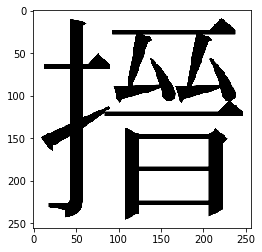

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


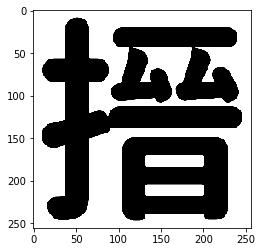

<generator object data_generators.iter_val at 0x7f60ba0b8d00>

In [13]:
x, y = generators.train_queue.get()
t = 0
# print(x[t])
# print(x[t].shape)
t = 0
plt.imshow(x[t])
plt.show()
plt.imshow(y[t])
plt.show()
generators.iter_val()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


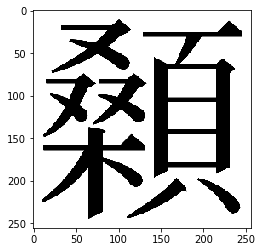

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [43]:
a = generators.iter_val().__next__()
plt.imshow(a[0][0])
plt.show()
a[0][0]

In [26]:
import os
len(os.listdir("png_aa"))

3415

Epoch: 0/900
train_G_loss: 26.330 train_D_loss: 0.666
val_G_loss: 25.420 val_D_loss: 9.650


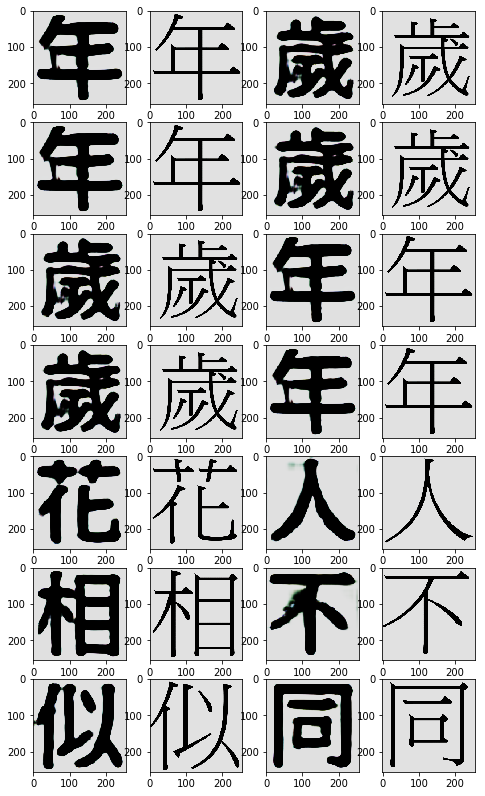

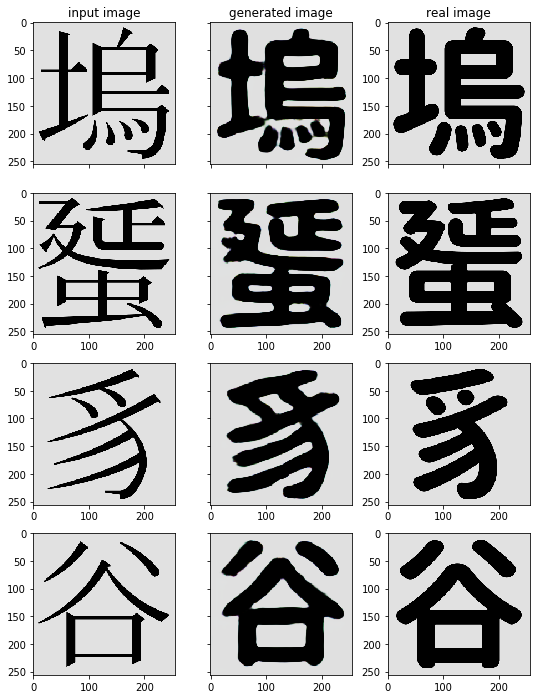

############################


Epoch: 1/900
train_G_loss: 24.676 train_D_loss: 1.691
val_G_loss: 24.448 val_D_loss: 10.893


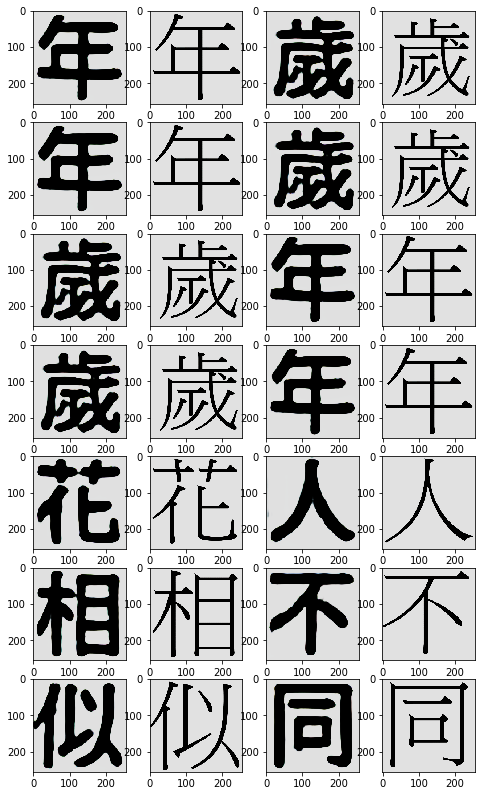

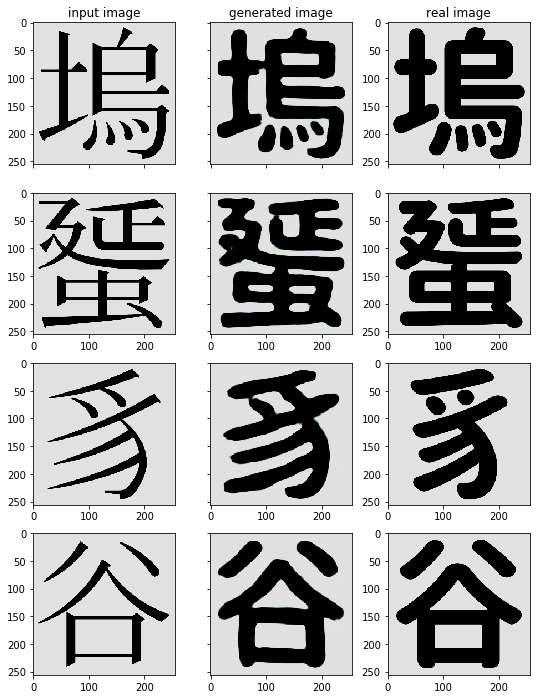

############################


Epoch: 2/900
train_G_loss: 23.622 train_D_loss: 0.571
val_G_loss: 23.928 val_D_loss: 11.622


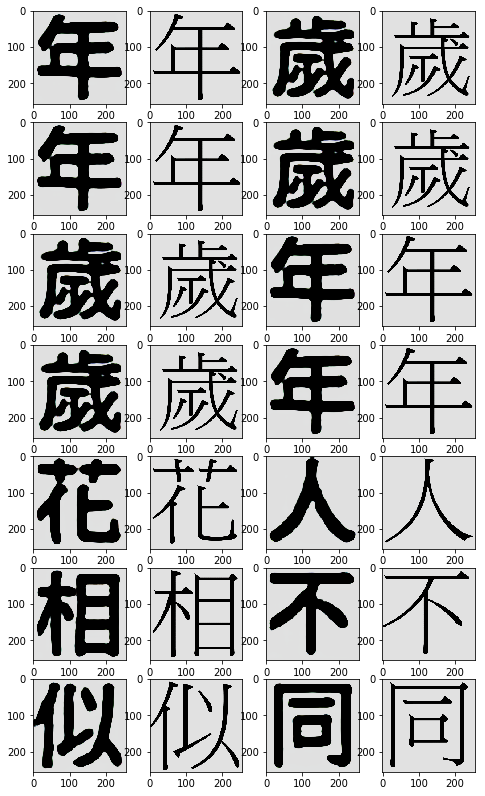

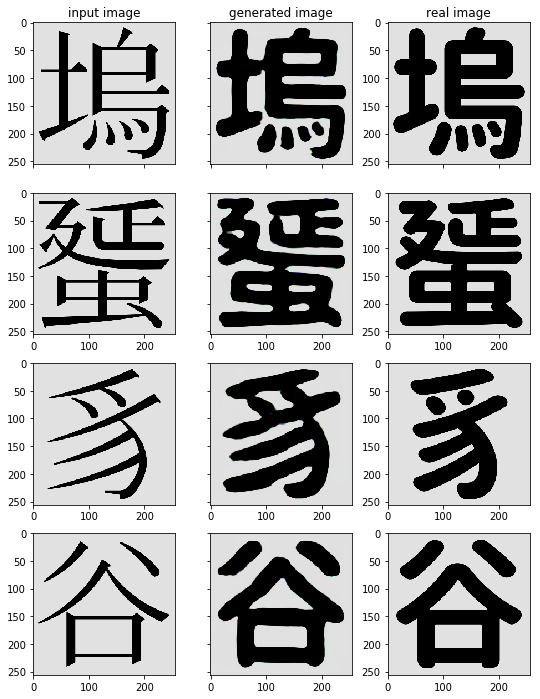

############################


KeyboardInterrupt: 

In [50]:
epoch_bar = tqdm(range(nb_epoch), desc="epoch", unit="epoch")
for epoch in epoch_bar:

    ### train ###
    train_batch_bar = tqdm(range(n_batch), desc="train_batch", unit="batch", leave=False)

    for batch in train_batch_bar:
        x, y = generators.train_queue.get()
        
        # 執行 loss & update (train)
        _, discriminator_loss = sess.run([D_update, D_loss], feed_dict={real_img_A:x, real_img_B:y, is_training:True })
        model_dict['train_batch_log'].push({'d_loss':discriminator_loss})
        
        _, generator_loss = sess.run([G_update, G_loss], feed_dict={real_img_A:x, real_img_B:y, is_training:True })
        model_dict['train_batch_log'].push({'g_loss':generator_loss})
    
    model_dict['history']['train_g_loss'].append(model_dict['train_batch_log'].avg_value('g_loss'))
    model_dict['history']['train_d_loss'].append(model_dict['train_batch_log'].avg_value('d_loss'))
    model_dict['train_batch_log'].reset()

    ### val ###
    val_batch_bar = tqdm(generators.iter_val(), total=generators.val_len, desc="val_batch" , unit="batch", leave=False)

    val_image_pair = []
    for x, y, length in val_batch_bar:
        # 執行 loss and generate image (val)
        # 小提醒： model 有使用 batch normalization。所以在非 training 階段， 
        # is_training要記得設定為 False。這樣 BN 層內的 mean, variance 才不會更新。
        generator_loss, discriminator_loss, generate_img = \
        sess.run([G_loss, D_loss, fake_img_B], feed_dict={real_img_A: x, real_img_B: y, is_training: False})
        # 選四對真實和生成的影像
        
        val_image_pair = [x[:4], generate_img[:4], y[:4]] 
        model_dict['val_batch_log'].push({'g_loss':generator_loss, 'd_loss':discriminator_loss}, length)


    model_dict['history']['val_g_loss'].append(model_dict['val_batch_log'].avg_value('g_loss'))
    model_dict['history']['val_d_loss'].append(model_dict['val_batch_log'].avg_value('d_loss'))
    model_dict['val_batch_log'].reset()

    
    ### callback ###
    print('Epoch: {}/{}'.format(epoch,nb_epoch))
    print('train_G_loss: {:.3f}'.format(model_dict['history']['train_g_loss'][-1]),
         'train_D_loss: {:.3f}'.format(model_dict['history']['train_d_loss'][-1]))
    print('val_G_loss: {:.3f}'.format(model_dict['history']['val_g_loss'][-1]),
         'val_D_loss: {:.3f}'.format(model_dict['history']['val_d_loss'][-1]))

    path = os.getcwd()
    f = "年年歲歲花相似歲歲年年人不同"
    img_xx = []
    for file_name in f:
        x = cv2.imread( file_name + ".png") #path + "/png_aa/" +
        x = (cv2.resize(x, (img_size, img_size))/255-0.5)*2
        img_xx.append(x)
    result_img = sess.run([fake_img_B], feed_dict = {real_img_A:img_xx, is_training : False})

    fig, axarr = plt.subplots(7, 4, figsize=(8,14))
    for i in range(len(f)//2):
        axarr[i, 0].imshow((((result_img[0][i])/2+0.5)*225).astype(np.uint8))
        axarr[i, 1].imshow((((img_xx[i])/2+0.5)*225).astype(np.uint8))
        axarr[i, 2].imshow((((result_img[0][i+7])/2+0.5)*225).astype(np.uint8))
        axarr[i, 3].imshow((((img_xx[i+7])/2+0.5)*225).astype(np.uint8))



    ### draw image ###
    if epoch%1 == 0:
        fig = plot(val_image_pair)
        plt.show()
        plt.close(fig)

#     callback_manager.run_on_epoch_end(val_loss = model_dict['history']['val_g_loss'][-1],
#                                       sess = sess,
#                                       saver = saver,
#                                       nth_epoch = epoch)
    print('############################')